<a href="https://colab.research.google.com/github/Ashi743/pytorch/blob/main/CNN_vgg_16_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [ ]:
torch.manual_seed(42)

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.csv'):  # Check if the file ends with '.csv'
            files = os.path.join(dirname, filename)
            print(files)

100%|██████████| 68.8M/68.8M [00:00<00:00, 82.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv
/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv


In [ ]:
train= pd.read_csv("/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv")

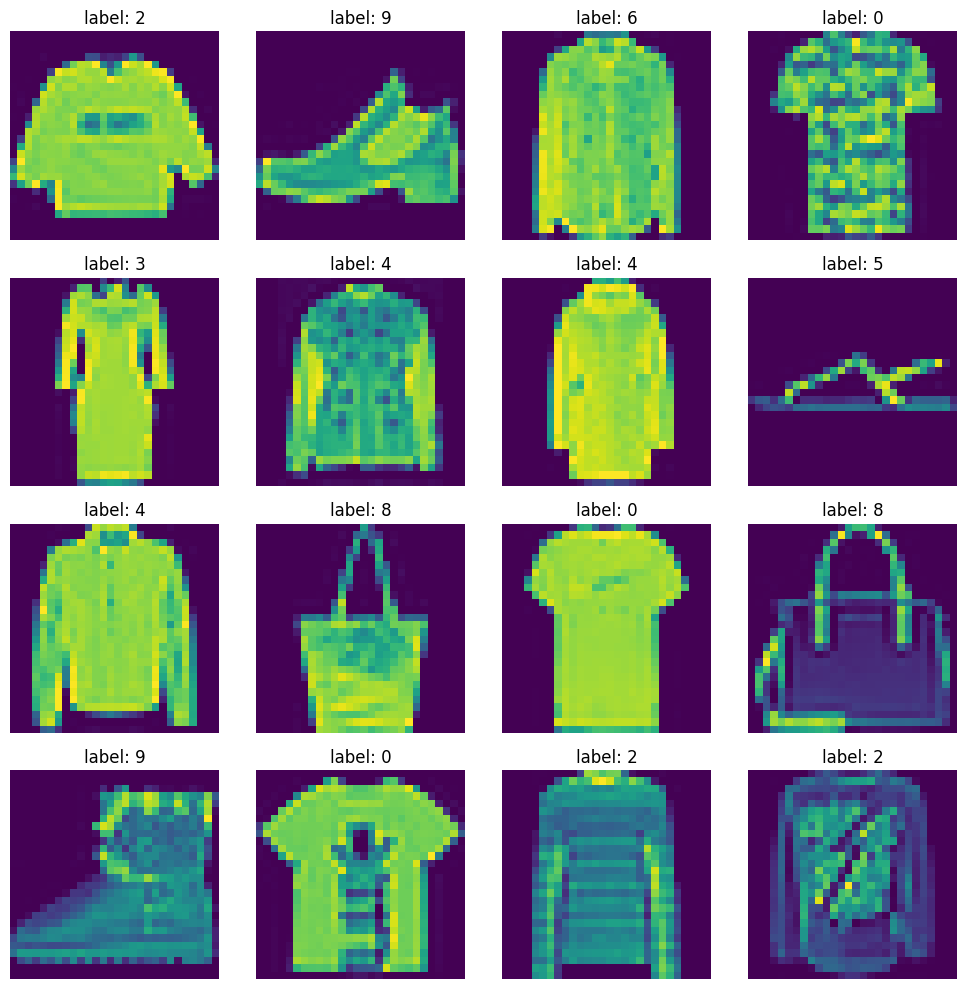

In [ ]:
fig, ax= plt.subplots(4,4, figsize=(10,10))

for i, ax in enumerate(ax.flat):
  img= train.iloc[i, 1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"label: {train.iloc[i,0]}")

plt.tight_layout()
plt.show()

In [ ]:
X= train.iloc[:, 1:].values
y= train.iloc[:, 0].values

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#transformation
from torchvision.transforms import transforms

custom_transform= transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from PIL import Image
import numpy as np

class customdataset(Dataset):
  def __init__(self, features, labels, transform):
    self.features= features
    self.labels= labels
    self.transform= transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    #resize (3,28, 28)
    image= self.features[index].reshape(28,28)

    #change datatype to np.uint8
    image= image.astype(np.uint8)

    #change b/w to color
    image= np.stack([image]*3, axis= -1)  #to  convert 1D to 3D  (H, W, C)--> (C, W, H)

    #change array to PIL
    image =Image.fromarray(image)

    #apply transform
    if self.transform is not None:
      image= self.transform(image)

    label= self.labels[index]

    return image, torch.tensor(label, dtype =torch.long)




In [ ]:
#dataset
train_dataset = customdataset(X_train, y_train, custom_transform)
test_dataset = customdataset(X_test, y_test, custom_transform)

In [ ]:
#dataloader
train_dataloader= DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader= DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
#use of pretrained model

#fetch from torch.visions.library

import torchvision.models as models
vgg16= models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.1MB/s]


In [ ]:
for param in vgg16.features.parameters():
  param.requires_grad= False  #FREEZE


In [ ]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
vgg16.classifier= nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=4096, out_features=1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=10)

                                  )

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16= vgg16.to(device)

In [ ]:
lr= 0.0001
epochs= 10


In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(vgg16.classifier.parameters(), lr=lr)

In [ ]:
#training loop
for epoch in range(epochs):
  total_epoch_loss= 0
  for batch_features, batch_labels in train_dataloader:
    batch_features,batch_labels= batch_features.to(device), batch_labels.to(device)

    optimizer.zero_grad()
    outputs= vgg16(batch_features)

    loss= criterion(outputs, batch_labels)
    loss.backward()
    optimizer.step()

    total_epoch_loss+= loss.item()

    break

  avg_loss= total_epoch_loss/len(train_dataloader)
  print(f"Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch: 1/10, Loss: 0.0015
Epoch: 2/10, Loss: 0.0015
Epoch: 3/10, Loss: 0.0015
Epoch: 4/10, Loss: 0.0015
Epoch: 5/10, Loss: 0.0015
Epoch: 6/10, Loss: 0.0015
Epoch: 7/10, Loss: 0.0015
Epoch: 8/10, Loss: 0.0014
Epoch: 9/10, Loss: 0.0014
Epoch: 10/10, Loss: 0.0014


In [ ]:
vgg16.eval()
total= 0
correct= 0
with torch.no_grad():
  for batch_features, batch_labels in test_dataloader:
    batch_features, batch_labels= batch_features.to(device), batch_labels.to(device)

    outputs= vgg16(batch_features)
    _, predicted= torch.max(outputs, dim=1)
    total+= batch_labels.size(0)
    correct+= (predicted== batch_labels).sum().item()

accuracy= correct/total
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 51.29%


In [ ]:
total= 0
correct= 0
with torch.no_grad():
  for batch_features, batch_labels in train_dataloader:
    batch_features, batch_labels= batch_features.to(device), batch_labels.to(device)

    outputs= vgg16(batch_features)
    _, predicted= torch.max(outputs, dim=1)
    total+= batch_labels.size(0)
    correct+= (predicted== batch_labels).sum().item()

accuracy= correct/total
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 51.26%
